In [1]:
pip install num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.6 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=a4fec5af6a393dff7d594d3c3bf7ae583da0c1602961f784530db1832250a8b7
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [2]:
import unicodedata
import random
import gensim
import pandas as pd
import numpy as np
import multiprocessing as mp

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter

import nltk
from nltk import ngrams
from nltk import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

from num2words import num2words

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import GradientBoostingClassifier

from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

from keras.preprocessing import sequence

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
name_file = '/content/result_anfx_clients_pro.csv'
df_client = pd.read_csv(name_file)

print(df_client.columns)
print(len(df_client.columns))
df_client.head()

Index(['Unnamed: 0', 'addon-pro', 'addon-pro-end-date', 'addon-pro-id',
       'addon-pro-is-active', 'addon-pro-start-date', 'addon-sto',
       'addon-sto-end-date', 'addon-sto-id', 'addon-sto-is-active',
       'addon-sto-start-date', 'company-city', 'company-country',
       'company-creation-date', 'company-deletion-date', 'company-door',
       'company-doorway', 'company-email', 'company-floor', 'company-id',
       'company-id-clean', 'company-is-actived', 'company-name',
       'company-phone', 'company-postal-code', 'company-province',
       'company-stair', 'company-street', 'nps-feedback', 'nps-previous-score',
       'nps-score', 'nps-score-old', 'nps-score-semaphore', 'nps-timestamp',
       'organization-email', 'organization-id', 'organization-id-clean',
       'organization-name', 'organization-phone', 'organization-type',
       'rtps-companent-list', 'rtps-total', 'subscription-active',
       'subscription-configuration-id', 'subscription-end-date',
       'subscri

,Unnamed: 0,addon-pro,addon-pro-end-date,addon-pro-id,addon-pro-is-active,addon-pro-start-date,addon-sto,addon-sto-end-date,addon-sto-id,addon-sto-is-active,...,subscription-configuration-id,subscription-end-date,subscription-expiration-date,subscription-id,subscription-is-uninstalled,subscription-name,subscription-start-date,user-access-email,user-is-actived,user-name
0,0,NaN,NaN,NaN,NaN,NaN,1.0,2022-08-30 23:59:59,8.0,0.0,...,822,NaN,NaN,48315608090546176,0,PROFESIONAL PROFIT ANUAL,2022-09-06 12:07:15,alderetearroyosl@gmail.com,1,DAVID MANZANO
1,1,1.0,2022-08-24 23:59:59,836.0,0.0,2020-11-30 11:43:48,1.0,2022-08-24 23:59:59,832.0,0.0,...,824,NaN,2022-08-24 23:59:59,32210918034378752,0,EMPRESARIAL PROFIT ANUAL,2018-10-15 09:50:01,scalper1@e-cos.es,1,Administración [Admin]
2,2,1.0,NaN,835.0,1.0,2022-06-21 18:20:42,1.0,2019-01-04 18:21:46,827.0,0.0,...,821,NaN,NaN,47446538691022848,0,PROFESIONAL PROFIT MENSUAL,2022-06-21 18:19:22,hola@karlospascual.com,1,Carlos Pascual
3,3,NaN,NaN,NaN,NaN,NaN,1.0,2020-07-26 14:18:16,831.0,0.0,...,821,NaN,NaN,39607750653120512,0,PROFESIONAL PROFIT MENSUAL,2020-07-29 13:45:56,julian.decabo@gmail.com,1,Julián de Cabo
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,822,NaN,2020-02-02 12:44:44,33174091499835392,0,PROFESIONAL PROFIT ANUAL,2019-01-08 10:03:52,marta@sumate.eu,1,Marta Delgado


Mostraremos la distribución del nps

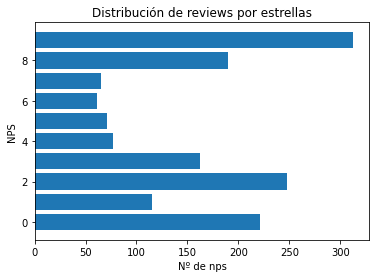

In [5]:
df_nps = df_client['nps-score']
df_nps = df_nps.dropna()

count_to_nps = df_nps.value_counts()

nps = df_nps.unique()

plt.barh(nps, count_to_nps)
plt.title('Distribución de reviews por estrellas')
plt.xlabel('Nº de nps')
plt.ylabel('NPS')
plt.show()

Distribución por el semáforo

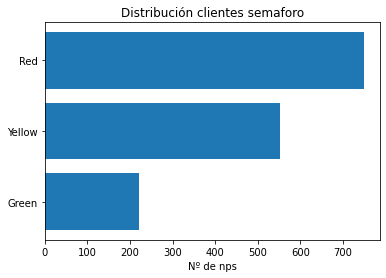

In [6]:
semaphore_green = len(df_client[df_client['nps-score'] >= 9])
semaphore_yellow = len(df_client[(df_client['nps-score'] >= 6) & (df_client['nps-score'] <= 8)])
semaphore_red = len(df_client[df_client['nps-score'] <= 5])

plt.barh(['Green','Yellow', 'Red'],[semaphore_green, semaphore_yellow, semaphore_red])
plt.title('Distribución clientes semaforo')
plt.xlabel('Nº de nps')
plt.show()

Analisis de texto según lo tenemos en el data set

In [7]:
# Metodo para obtener el numero total de reviews
def total_number_of_reviews(df):
  df_aux = df.dropna()
  return df_aux.shape[0]

In [8]:
number_feedback = total_number_of_reviews(df_client['nps-feedback'])
print(f'Tenemos un total de {number_feedback} feedback.')

Tenemos un total de 311 feedback.


In [9]:
# Metodo para obtener el numero total de frases
def total_number_of_sentences(df):
  sentences = list()
  for review in df.dropna().values:
    for sentnce in review[0].split('.'):
      sentences.append(sentnce)

  return len(sentences)

In [10]:
number_sentences = total_number_of_sentences(df_client['nps-feedback'])
print(f'Tenemos un total de {number_sentences} frases.')

Tenemos un total de 318 frases.


In [11]:
# Metodo para obtener el numero total de tokens o palabras
def total_number_of_tokens(df):
  tokens = list()
  for review in df.dropna().values:
    for token in review[0].split():
      tokens.append(token)

  return len(tokens)

In [12]:
number_tokens = total_number_of_tokens(df_client[['nps-feedback']])
print(f'Tenemos un total de {number_tokens} palabras o tokens.')

Tenemos un total de 4717 palabras o tokens.


In [13]:
# Metodo para obtener los tokens o palabras
def extract_tokens_from_a_DataFrame(df):
  tokens = list()
  for review in df.dropna().values:
    for token in review[0].split():
      tokens.append(token)

  return tokens

In [14]:
# Almacenaremos el total de los tokens
words_totals = extract_tokens_from_a_DataFrame(df_client[['nps-feedback']])
words_totals = [x.lower() for x in words_totals]

In [15]:
# Metodo para generar un grafico de tipo nuve de palabras
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

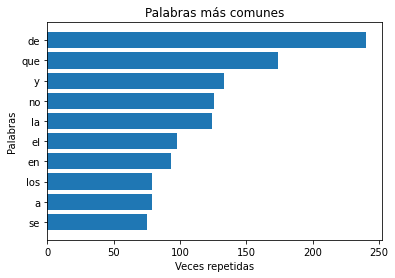

In [16]:
count_words = Counter(words_totals)
w_most_common = count_words.most_common(10)
words = [w[0] for w in w_most_common]
freqs = [w[1] for w in w_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.title('Palabras más comunes')
plt.xlabel('Veces repetidas')
plt.ylabel('Palabras')
plt.show()

In [17]:
# generamos los n-grams
bigrams_ = list(ngrams(words_totals, 2))
trigrams_ = list(ngrams(words_totals, 3))

# calculamos la frecuencias
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

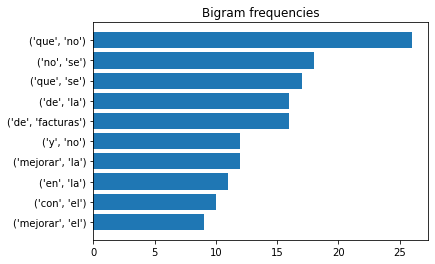

In [18]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

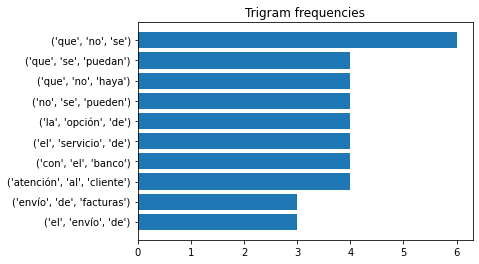

In [19]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

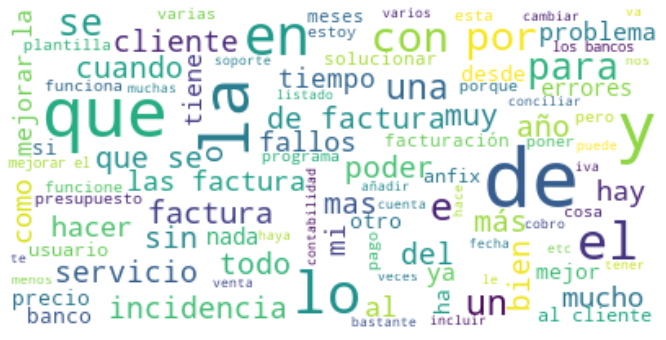

In [20]:
plot_word_cloud(words_totals)

Sin stop words

In [21]:
# Lista con las Stop Words
stopword_es = nltk.corpus.stopwords.words('spanish')

In [22]:
# Almacenaremos el total de los tokens sin Stop Words
words_totals_no_sw = [word for word in words_totals if word not in stopword_es]

El número de reviews y de frases será el mismo que antes pero el número de palabras es el que va a cambiar, así como los N-grams o la nuve de palabras, al eliminar las Stop Words de nuestras reviews.

In [23]:
print(f'Tenemos un total de {len(words_totals_no_sw)} palabras o tokens sin las Stop Words.')

Tenemos un total de 2564 palabras o tokens sin las Stop Words.


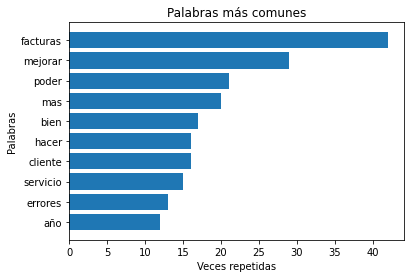

In [24]:
count_words_no_ws = Counter(words_totals_no_sw)
w_most_common = count_words_no_ws.most_common(10)
words = [w[0] for w in w_most_common]
freqs = [w[1] for w in w_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.title('Palabras más comunes')
plt.xlabel('Veces repetidas')
plt.ylabel('Palabras')
plt.show()

In [25]:
# N-grams

# generamos los n-grams
bigrams_no_sw = list(ngrams(words_totals_no_sw, 2))
trigrams_no_sw = list(ngrams(words_totals_no_sw, 3))

# calculamos la frecuencias
bg_freq_no_sw = FreqDist(bigrams_no_sw)
tg_freq_no_sw = FreqDist(trigrams_no_sw)

bg_freq_most_common_no_sw = bg_freq_no_sw.most_common(10)
bgs_no_sw = [str(bg[0]) for bg in bg_freq_most_common_no_sw]
bgs_f_no_sw = [bg[1] for bg in bg_freq_most_common_no_sw]

tg_freq_most_common_no_sw = tg_freq_no_sw.most_common(10)
tgs_no_sw = [str(tg[0]) for tg in tg_freq_most_common_no_sw]
tgs_f_no_sw = [tg[1] for tg in tg_freq_most_common_no_sw]

bgs_f_no_sw, bgs_no_sw = zip(*sorted(zip(bgs_f_no_sw, bgs_no_sw)))
tgs_f_no_sw, tgs_no_sw = zip(*sorted(zip(tgs_f_no_sw, tgs_no_sw)))

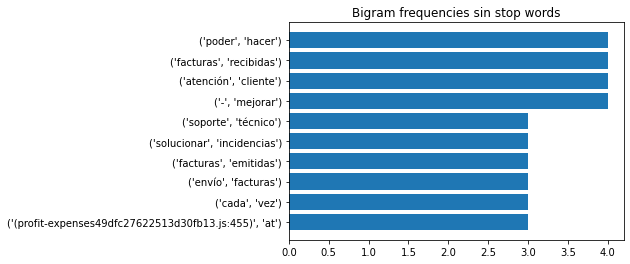

In [26]:
plt.barh(bgs_no_sw, bgs_f_no_sw)
plt.title('Bigram frequencies sin stop words')
plt.show()

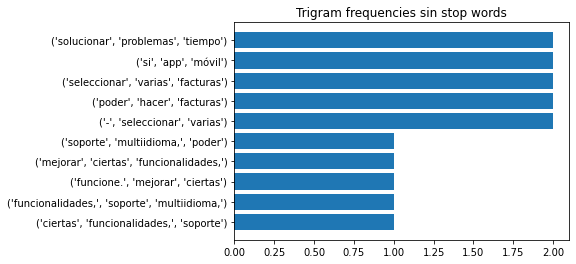

In [27]:
plt.barh(tgs_no_sw, tgs_f_no_sw)
plt.title('Trigram frequencies sin stop words')
plt.show()

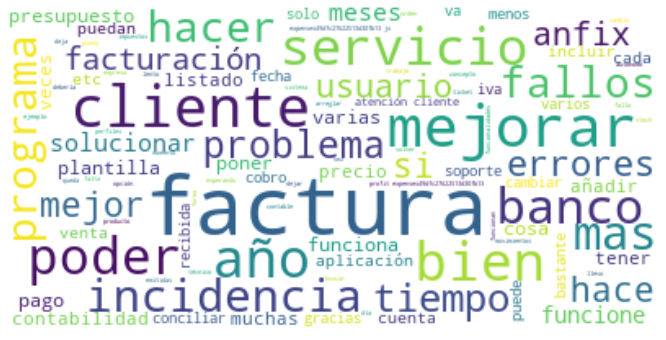

In [28]:
plot_word_cloud(words_totals_no_sw)

Etapa del procesado de texto

In [29]:
# Método eliminación de acentos, etc
def regularize_unicode(text):
  clean_text = ''
  clean_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return clean_text

# Método para eliminar stop words
def delete_stop_words(text, sw_list=nltk.corpus.stopwords.words('spanish')):
  clean_text = ''
  clean_text = ' '.join([word for word in text.lower().split() if word not in sw_list])
  return clean_text


# Método para regularizar en mayusculas o minusculas
def regularize_lowercase(text, tokenizer):
  clean_text = list()

  for word in tokenizer.tokenize(text):
    clean_word = word.lower()
    clean_text.append(clean_word)

  return ' '.join(clean_text)


# Método lematizar
def regularize_lemat(text, tokenizer, lemmatizer):
  clean_text = list()

  for word in tokenizer.tokenize(text):
    clean_word = lemmatizer.lemmatize(word)
    clean_text.append(clean_word)

  return ' '.join(clean_text)


# Método para eliminar espacios sobrantes
import string
def regularize_spaces(text):
  table = str.maketrans('', '', string.punctuation)
  clean_text = ' '.join([word.translate(table) for word in text.split()])
  return clean_text


# Método convertir dígitos a palabras
def regularize_convert_digits_to_words(text, tokenizer):
  clean_text = list()

  for word in tokenizer.tokenize(text):
    if word.isdigit():
      clean_word = num2words(word, lang='es')
      clean_text.append(clean_word)
    else:
      clean_text.append(word)

  return ' '.join(clean_text)

In [30]:
# Método de procesamiento general del texto
def pipeline_cleaner(text_list):

  clean_text = list()
  tokenizer = RegexpTokenizer(r'\w+')
  lemmatizer = WordNetLemmatizer()

  for i in range(len(text_list)):
    text_clean = regularize_unicode(text_list[i])
    text_clean = regularize_lowercase(text_clean, tokenizer)
    text_clean = delete_stop_words(text_clean, stopword_es)
    text_clean = regularize_lemat(text_clean, tokenizer, lemmatizer)
    text_clean = regularize_convert_digits_to_words(text_clean, tokenizer)
    text_clean = regularize_spaces(text_clean)
    clean_text.append(text_clean)

  return clean_text

In [33]:
df_client_clean = df_client[df_client['nps-feedback'].notna()]

nps_feedback = pipeline_cleaner(df_client_clean['nps-feedback'].tolist())
nps_score = df_client_clean['nps-score']

df_model = pd.DataFrame({
    'feedback': nps_feedback,
    'score': nps_score
})
df_model.dropna(subset=['feedback', 'score'], inplace=True)
df_model.reset_index(drop=True, inplace=True)

In [32]:
stopword_es.append('1o')
stopword_es.append('2o')

In [34]:
df_model.head(10)

,feedback,score
0,funcione,0.0
1,mejorar ciertas funcionalidades soporte multii...,0.0
2,caiga facturas emitidas orden,0.0
3,caido calidad servicio llevo incidencias ano p...,0.0
4,ma rapida contabilizacion,6.0
5,quedan consultas soporte tecnico responder,6.0
6,mejorar fallos ultimamente aumentan,5.0
7,unificar forma trabajar facturas presupuesto i...,3.0
8,anfix parecio solucion perfecta economica cont...,6.0
9,habilitar perfiles usuario accesos diferenciad...,5.0


In [35]:
# Metodo por el que a partir de la puntuación lo convertimos en semaforo
def label_semaphore(row):
  if int(row['score']) <= 6:
    return 1
  else:
    return 0

In [36]:
df_model["semaphore"] = df_model.apply(lambda row: label_semaphore(row), axis=1)

In [37]:
df_model.head(10)

,feedback,score,semaphore
0,funcione,0.0,1
1,mejorar ciertas funcionalidades soporte multii...,0.0,1
2,caiga facturas emitidas orden,0.0,1
3,caido calidad servicio llevo incidencias ano p...,0.0,1
4,ma rapida contabilizacion,6.0,1
5,quedan consultas soporte tecnico responder,6.0,1
6,mejorar fallos ultimamente aumentan,5.0,1
7,unificar forma trabajar facturas presupuesto i...,3.0,1
8,anfix parecio solucion perfecta economica cont...,6.0,1
9,habilitar perfiles usuario accesos diferenciad...,5.0,1


In [38]:
# Almacenaremos el total de los tokens
words_totals_processed = extract_tokens_from_a_DataFrame(df_model[['feedback']])

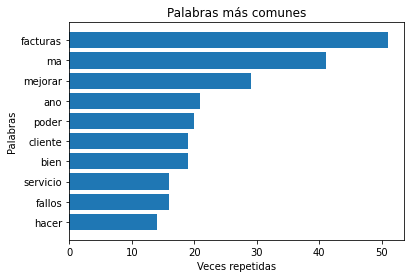

In [39]:
count_words_processed = Counter(words_totals_processed)
w_most_common = count_words_processed.most_common(10)
words = [w[0] for w in w_most_common]
freqs = [w[1] for w in w_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.title('Palabras más comunes')
plt.xlabel('Veces repetidas')
plt.ylabel('Palabras')
plt.show()

In [40]:
# N-grams

# generamos los n-grams
bigrams_no_sw = list(ngrams(count_words_processed, 2))
trigrams_no_sw = list(ngrams(count_words_processed, 3))

# calculamos la frecuencias
bg_freq_no_sw = FreqDist(bigrams_no_sw)
tg_freq_no_sw = FreqDist(trigrams_no_sw)

bg_freq_most_common_no_sw = bg_freq_no_sw.most_common(15)
bgs_no_sw = [str(bg[0]) for bg in bg_freq_most_common_no_sw]
bgs_f_no_sw = [bg[1] for bg in bg_freq_most_common_no_sw]

tg_freq_most_common_no_sw = tg_freq_no_sw.most_common(15)
tgs_no_sw = [str(tg[0]) for tg in tg_freq_most_common_no_sw]
tgs_f_no_sw = [tg[1] for tg in tg_freq_most_common_no_sw]

bgs_f_no_sw, bgs_no_sw = zip(*sorted(zip(bgs_f_no_sw, bgs_no_sw)))
tgs_f_no_sw, tgs_no_sw = zip(*sorted(zip(tgs_f_no_sw, tgs_no_sw)))

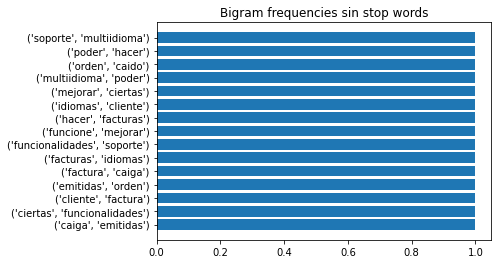

In [41]:
plt.barh(bgs_no_sw, bgs_f_no_sw)
plt.title('Bigram frequencies sin stop words')
plt.show()

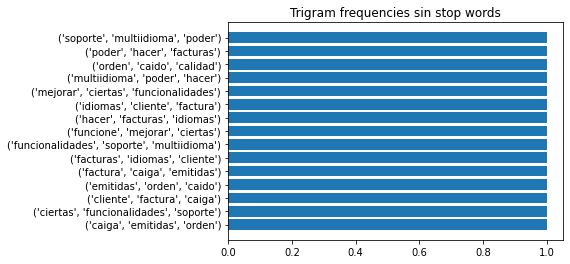

In [42]:
plt.barh(tgs_no_sw, tgs_f_no_sw)
plt.title('Trigram frequencies sin stop words')
plt.show()

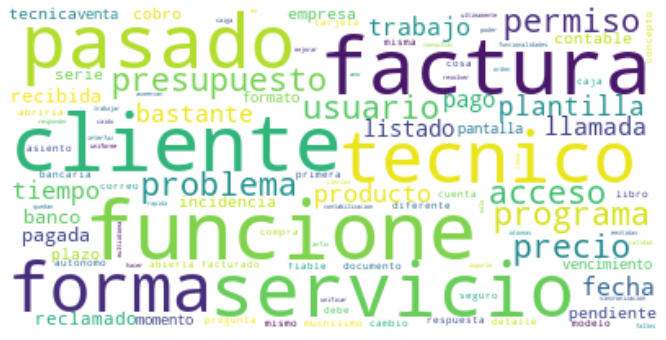

In [43]:
plot_word_cloud(count_words_processed)

##3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

Vamos a realizar el split de los datos con los que vamos a trabajar. El conjunto de datos no es muy grande por lo que solo vamos a dividir en Train y Test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model['feedback'],
    df_model['semaphore'],
    train_size=0.90,
    test_size=0.10,
    random_state=42,
    shuffle=True
)

In [45]:
# Comprobamos que en la parte de data frame de entrenamiento tenemos solo los textos
X_train.iloc[:10]

9      habilitar perfiles usuario accesos diferenciad...
118    llevamos ma tres ano incidencias siempre dan m...
22     bajar precios ofrecer mejor plataforma concili...
155    permita poner observaciones automaticas person...
24                   funciona navegador ipad app va bien
167    programa agil seleccionas ejercicio repente in...
225    fallos app web solucionar varios me captura fa...
75                                                      
233    seria genial importara bien facturas poniendo iva
262                             enganar atender clientes
Name: feedback, dtype: object

In [46]:
# Comprobamos que en la parte de data frame de etiquetas tenemos solo la parte binaria
y_train.iloc[:10]

9      1
118    1
22     1
155    0
24     1
167    1
225    0
75     0
233    1
262    1
Name: semaphore, dtype: int64

Como vamos a trabajar con el sentimiento de los textos, en un clasificador, es buena practica utilizar n-gramas puesto que nos ayuda a contextualizar los textos y esto mejora las capacidades del modelo a la hora de predecir el sentimiento.

In [47]:
cv = CountVectorizer(
    max_df=0.95,
    min_df=1,
    max_features=1000, #1000
    strip_accents='ascii',
    ngram_range=(1, 3)
)
cv.fit(X_train)

CountVectorizer(max_df=0.95, max_features=1000, ngram_range=(1, 3),
                strip_accents='ascii')

In [48]:
# aplicamos el modelo entrenado a los datos para obtener su representacion 
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

#Análisis de sentimiento con ML (LogisticRegression)

Vamos a entrenar el modelo con varias configuraciones para ver cual tiene mejor rendimiento.

In [49]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

test_pred = list()
train_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

    test_pred.append(test_predict)

Accuracy for C=0.01: 0.6785714285714286
Accuracy for C=0.05: 0.7142857142857143
Accuracy for C=0.25: 0.6785714285714286
Accuracy for C=0.5: 0.6785714285714286
Accuracy for C=1: 0.6785714285714286
Accuracy for C=10: 0.6428571428571429
Accuracy for C=100: 0.6785714285714286
Accuracy for C=1000: 0.7142857142857143
Accuracy for C=10000: 0.7142857142857143


In [50]:
result_test_predict = test_pred[7]

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, result_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, result_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, result_test_predict)))

Confussion matrix:
[[ 3  6]
 [ 2 17]]

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.74      0.89      0.81        19

    accuracy                           0.71        28
   macro avg       0.67      0.61      0.62        28
weighted avg       0.69      0.71      0.69        28

Accuracy score:0.7142857142857143


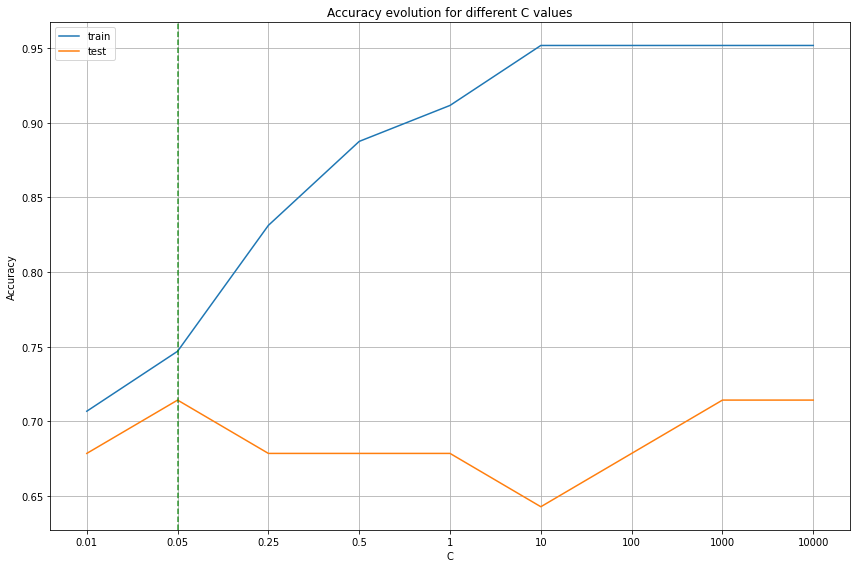

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

##Modelo seleccionado para probarlo.

In [52]:
modelo_ok = LogisticRegression(C=1000, solver='lbfgs', max_iter=1500)
modelo_ok.fit(X_train_, y_train)

LogisticRegression(C=1000, max_iter=1500)

In [53]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df_model.iloc[review_index]['semaphore']))
    r = df_model.iloc[review_index]['feedback']
    print('Prediction: {}'.format(modelo_ok.predict(cv.transform([r]))))

In [54]:
for i in random.sample(range(0, len(df_model)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, modelo_ok)


Review no. 217
Actual sentiment: 0
Prediction: [0]

Review no. 54
Actual sentiment: 0
Prediction: [0]

Review no. 220
Actual sentiment: 1
Prediction: [1]

Review no. 137
Actual sentiment: 0
Prediction: [0]

Review no. 92
Actual sentiment: 1
Prediction: [1]

Review no. 159
Actual sentiment: 1
Prediction: [1]

Review no. 175
Actual sentiment: 0
Prediction: [1]

Review no. 59
Actual sentiment: 1
Prediction: [1]

Review no. 194
Actual sentiment: 0
Prediction: [0]

Review no. 130
Actual sentiment: 1
Prediction: [1]
